In this tutorial, you are going to train a text classifier on the IMDB dataset using RNNs.

In [0]:
!pip install -q tf-nightly tfds-nightly
#!pip install -q tensorflow_datasets

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
from IPython.display import clear_output
import matplotlib.pyplot as plt

tfds.disable_progress_bar()

print("Tensorflow Version: {}".format(tf.__version__))
print("GPU {} available.".format("is" if tf.config.experimental.list_physical_devices("GPU") else "not"))

Tensorflow Version: 2.2.0-dev20200212
GPU is available.


The function `plot_history` helps you plot the training status.

In [0]:
def plot_history(history, metrics):
  plt.figure(figsize=(9, 6))
  plt.plot(history.history[metrics], label="Training")
  plt.plot(history.history["val_" + metrics], label="Validation")
  plt.xlabel('Epochs')
  plt.ylabel(metrics)
  plt.legend()
  plt.show()

# Input Pipeline

In [3]:
dataset, info = tfds.load(name="imdb_reviews/subwords8k", with_info=True, as_supervised=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0.incomplete7KEKLY/imdb_reviews-train.tfrecord
Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0.incomplete7KEKLY/imdb_reviews-test.tfrecord
Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0.incomplete7KEKLY/imdb_reviews-unsupervised.tfrecord
Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0. Subsequent calls will reuse this data.


The info of the dataset contains the encoder for words.

In [4]:
encoder = info.features['text'].encoder
print('Vocabulary Size: {}'.format(encoder.vocab_size))
print('The first few words: \n{}'.format('\n'.join(encoder.subwords[:10])))

Vocabulary Size: 8185
The first few words: 
the_
, 
. 
a_
and_
of_
to_
s_
is_
br


The encoder can encode a word into an integer list. This list can also be decoded back to the same word.

In [5]:
example_string = 'Hello world, RNN in Tensorflow.'

encoded_string = encoder.encode(example_string)
print("Encoded integer list: {}".format(encoded_string))

decoded_string = encoder.decode(encoded_string)
print('Decoded from an integer list: {}'.format(decoded_string))

assert decoded_string == example_string

Encoded integer list: [4025, 222, 562, 2, 8011, 8007, 1978, 11, 6307, 2327, 2934, 7975]
Decoded from an integer list: Hello world, RNN in Tensorflow.


In [6]:
for index in encoded_string:
  print("{} <-> {}".format(index, encoder.decode([index])))

4025 <-> Hell
222 <-> o 
562 <-> world
2 <-> , 
8011 <-> R
8007 <-> N
1978 <-> N 
11 <-> in 
6307 <-> Ten
2327 <-> sor
2934 <-> flow
7975 <-> .


In [0]:
BUFFER_SIZE = 10000
batch_size = 64

Next, we are going to create batches of these strings. Use the `padded_batch` to pad zeros at the end of the sequences to make the batch of sequences the same length. If the `padded_shapes ` was not set, the default `padded_shape` value is the maximum value o the batch sequence.

In [0]:
train_dataset = train_dataset.shuffle(BUFFER_SIZE).padded_batch(batch_size, padded_shapes=([-1], []))
test_dataset = test_dataset.padded_batch(batch_size, padded_shapes=([-1], []))

Let's take a look at these batch data. The sequence length is variable among batch data.

In [9]:
for seq, label in train_dataset.take(2):
  print(seq.shape, label.shape)
  print("Label: {}, Data: {}".format(label[0].numpy(), seq[0].numpy()))

(64, 1231) (64,)
Label: 1, Data: [7180    2    4 ...    0    0    0]
(64, 1223) (64,)
Label: 1, Data: [  19  651 3966 ...    0    0    0]


# Create the Model

Let's try the LSTMCell layer first. 

The `tf.keras.layers.Bidirectional` API provides an easier way to construct a bidirectional mechanism of RNN cells. It can be composed of different RNN cells, like LSTM, GRU or simple RNN cell. The composed cell is a real operating unit, in this case, we use LSTM cells as the unit. When we construct an LSTM layer, five basic parameters are required to be known. 

First, the `return_sequence` flag is used for returning the last output (default is set to False) or the full sequence (True). If the flag is set to True, the output sequence dimension would become [batch_size, sequence_length, lstm_cell_output_dim] instead of [batch_size, lstm_cell_output_dim] (when it is at default value).

The `return_state` flag is used for whether to return the last state (default is set to False). If the flag is set to True, it would return three states sequentially, the sequence output, the final memory state, and the final carry state.

![LSTM Cell](https://www.mdpi.com/water/water-11-01387/article_deploy/html/images/water-11-01387-g004-550.jpg)

Refer to Xuan-Hien Le, etc. (2019) 

The `go_backwards` flag (default is set to False) helps you to reverse the input vector. In the previous studies, they showed better performance when the input vector was reversed in some cases.

The `stateful` flag (default is set to False) helps you to initialize the cell with a pre-existing state.

The `time_major` flag (default is set to False) helps you to train a model on the time major dataset. When the flag is set to True, the shape of batch time would become (timestamps, batch_size, features) instead of (batch_size, timestamps, features) (the default shape).

In [10]:
x = tf.random.normal([1, 20, 30])  # [Batch, Sequence_Length, Embedded_Vector_Length]
lstm = tf.keras.layers.LSTM(64, return_state=True, return_sequences=True)(x)
whole_sequence_output, final_memory_state, final_carry_state = lstm
whole_sequence_output.shape, final_memory_state.shape, final_carry_state.shape

(TensorShape([1, 20, 64]), TensorShape([1, 64]), TensorShape([1, 64]))

Next, let's try the bidirectional layer. The bidirectional layer is a mechanism looking for a long timestamp relationship. There are two core parameters used for building a bidirectional layer.

The `layer` parameter is used for the recurrent instance, or say the forward instance.

The `backward_layer` is used for another recurrent instance but it is backward (from the end to the start). If no recurrent instance was assigned to the backward layer, it would use the same instance with the one assigned in the `layer` parameter.

Because the bidirectional layer is composed of both the forward layer and the backward layer, the output of the bidirectional layer is double than of a recurrent layer.

In [11]:
x = tf.random.normal([1, 20, 30])  # (batch_size, timestamps, features)
bi = tf.keras.layers.Bidirectional(
  layer=tf.keras.layers.LSTM(64, return_sequences=True, return_state=True)
)(x)
returned_sequence, layer_memory_state, layer_carry_state, backward_memory_state, backward_carry_state = bi
returned_sequence.shape, layer_memory_state.shape, layer_carry_state.shape, backward_memory_state.shape, backward_carry_state.shape

(TensorShape([1, 20, 128]),
 TensorShape([1, 64]),
 TensorShape([1, 64]),
 TensorShape([1, 64]),
 TensorShape([1, 64]))

Next, we are going to create a text classifier. It first comes with an `embedding layer` to convert an integer list (represents a sentence) to the embedding vectors. The embedding layer is initialized as random float values. After training the text classification, the embedding layer is also trained and is potential for the dense representation between words.

Second, `a bidirectional layer of LSTM cells` takes the output of the embedding layers. This layer consumes the embedding value iteratively, representing passing the value a timestamp by a timestamp. The bidirectional layer is the potential for a long time relationship between words.

Finally, we add `two dense layers` to do the classification task.

In [0]:
def build_model():
  def _model(inputs):
    embed = tf.keras.layers.Embedding(input_dim=encoder.vocab_size, output_dim=64)(inputs)  # [None, None, 64]
    bi_lstm = tf.keras.layers.Bidirectional(
      tf.keras.layers.LSTM(units=64)
    )(embed)                                                                                # [None, 64*2]
    x = tf.keras.layers.Dense(units=64, activation='relu')(bi_lstm)                         # [None, 64]
    classifier = tf.keras.layers.Dense(units=1)(x)                                          # [None, 1]
    return classifier

  inputs = tf.keras.Input(shape=(None, ))
  classifier = _model(inputs)
  return tf.keras.Model(inputs, classifier)

In [13]:
model = build_model()
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None)]            0         
_________________________________________________________________
embedding (Embedding)        (None, None, 64)          523840    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 128)               66048     
_________________________________________________________________
dense (Dense)                (None, 64)                8256      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 598,209
Trainable params: 598,209
Non-trainable params: 0
_________________________________________________________________


In [0]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), 
              optimizer=tf.keras.optimizers.Adam(1e-4), 
              metrics=[tf.keras.metrics.BinaryAccuracy()])

# Train the Model

In [15]:
history = model.fit(train_dataset, epochs=10, validation_data=test_dataset, validation_steps=20)

Epoch 1/10
391/391 [==============================] - 50s 129ms/step - loss: 0.6456 - binary_accuracy: 0.5595 - val_loss: 0.4751 - val_binary_accuracy: 0.7453
Epoch 2/10
391/391 [==============================] - 47s 121ms/step - loss: 0.3452 - binary_accuracy: 0.8507 - val_loss: 0.4176 - val_binary_accuracy: 0.8031
Epoch 3/10
391/391 [==============================] - 47s 121ms/step - loss: 0.2541 - binary_accuracy: 0.9009 - val_loss: 0.3594 - val_binary_accuracy: 0.8617
Epoch 4/10
391/391 [==============================] - 48s 122ms/step - loss: 0.2169 - binary_accuracy: 0.9172 - val_loss: 0.3358 - val_binary_accuracy: 0.8656
Epoch 5/10
391/391 [==============================] - 48s 122ms/step - loss: 0.1842 - binary_accuracy: 0.9359 - val_loss: 0.3665 - val_binary_accuracy: 0.8656
Epoch 6/10
391/391 [==============================] - 48s 122ms/step - loss: 0.1631 - binary_accuracy: 0.9441 - val_loss: 0.3855 - val_binary_accuracy: 0.8578
Epoch 7/10
391/391 [==========================

In [16]:
test_loss, test_acc = model.evaluate(test_dataset)

    391/Unknown - 18s 46ms/step - loss: 0.4979 - binary_accuracy: 0.8558

The above model does not `mask` the padding applied to the sequences. This causes a skew when applying the model (trained on padded sequences) to the un-padded sequences. More information please refer to https://www.tensorflow.org/guide/keras/masking_and_padding.


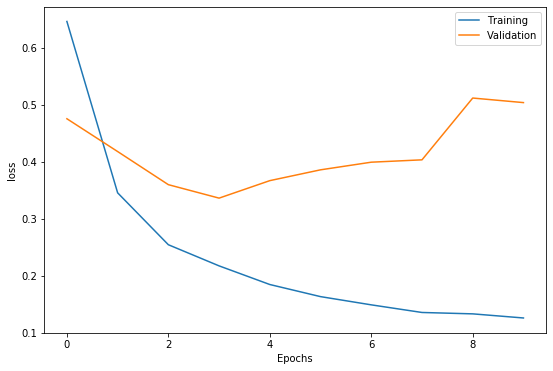

In [17]:
plot_history(history, 'loss')

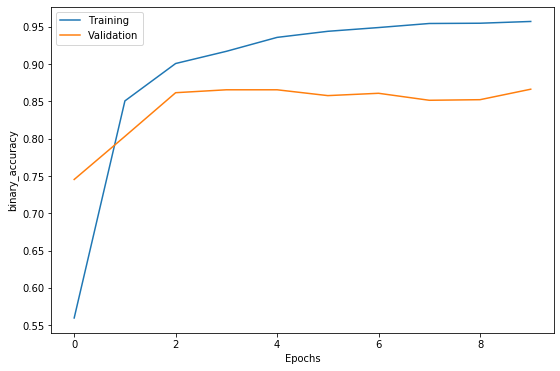

In [18]:
plot_history(history, 'binary_accuracy')

# Prediction

If the prediction is >= 0.5, it is positive else it is negative.

In [0]:
def padding(vec, size):
  if size <= len(vec):
    return vec[:size]
  zeros = [0] * (size - len(vec))
  vec.extend(zeros)
  return vec

In [0]:
def predict(used_model, pred_text, pad=False):
  encoded_text = encoder.encode(pred_text)

  if pad:
    encoded_text = padding(encoded_text, size=64)

  encoded_text = tf.cast(encoded_text, tf.float32)
  predictions = used_model.predict(encoded_text[tf.newaxis, ...])
  return predictions

In [21]:
sample_text = "The movie is overall nice, however, the story is ridiculous."
predictions = predict(model, sample_text, pad=True)
predictions

array([[-0.47524095]], dtype=float32)

# Stack More LSTM Layers

The following we are going to stack more LSTM layers to a model. Here, we stack a bidirectional LSTM layer upon the first one. However, a bidirectional LSTM layer would squeeze the timestamp dimension to return the sequence of the final layer. We have to set the `return_sequence` flag to True to keep the sequence alongside the timestamp axis. Now the shape would become [batch_size, timestamps, features]. We then pass these tensor into the next bidirectional LSTM layer.

In [0]:
def build_stack_model():
  def _model(inputs):
    embed = tf.keras.layers.Embedding(encoder.vocab_size, output_dim=64)(inputs)  # [None, None, 64]
    lstm1 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units=64, return_sequences=True))(embed)  # [None, None, 128]
    lstm2 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units=32))(lstm1)  # [None, 64]
    x = tf.keras.layers.Dense(64, activation='relu')(lstm2)  # [None, 64]
    x = tf.keras.layers.Dropout(0.5)(x)
    classifier = tf.keras.layers.Dense(1)(x)  # [None, 1]
    return classifier

  inputs = tf.keras.Input(shape=(None, ))
  classifier = _model(inputs)
  return tf.keras.Model(inputs, classifier)

In [23]:
stack_model = build_stack_model()
stack_model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, None)]            0         
_________________________________________________________________
embedding_1 (Embedding)      (None, None, 64)          523840    
_________________________________________________________________
bidirectional_2 (Bidirection (None, None, 128)         66048     
_________________________________________________________________
bidirectional_3 (Bidirection (None, 64)                41216     
_________________________________________________________________
dense_2 (Dense)              (None, 64)                4160      
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 65  

In [0]:
stack_model.compile(loss=tf.keras.losses.BinaryCrossentropy(), 
              optimizer=tf.keras.optimizers.Adam(1e-4), 
              metrics=[tf.keras.metrics.BinaryAccuracy()])

In [25]:
history = stack_model.fit(train_dataset, epochs=10, validation_data=test_dataset, validation_steps=20)

Epoch 1/10
391/391 [==============================] - 83s 212ms/step - loss: 1.0341 - binary_accuracy: 0.4999 - val_loss: 0.6838 - val_binary_accuracy: 0.5664
Epoch 2/10
391/391 [==============================] - 79s 203ms/step - loss: 0.6856 - binary_accuracy: 0.6010 - val_loss: 0.5801 - val_binary_accuracy: 0.7031
Epoch 3/10
391/391 [==============================] - 79s 203ms/step - loss: 0.5855 - binary_accuracy: 0.7532 - val_loss: 0.7490 - val_binary_accuracy: 0.8023
Epoch 4/10
391/391 [==============================] - 79s 202ms/step - loss: 0.5135 - binary_accuracy: 0.7888 - val_loss: 0.7528 - val_binary_accuracy: 0.8094
Epoch 5/10
391/391 [==============================] - 79s 202ms/step - loss: 0.7070 - binary_accuracy: 0.6302 - val_loss: 0.6264 - val_binary_accuracy: 0.6820
Epoch 6/10
391/391 [==============================] - 80s 205ms/step - loss: 0.5733 - binary_accuracy: 0.7048 - val_loss: 0.5610 - val_binary_accuracy: 0.7320
Epoch 7/10
391/391 [==========================

In [26]:
sample_text = "The movie is overall nice, however, the story is ridiculous."
predictions = predict(stack_model, sample_text, pad=True)
predictions

array([[-0.02119487]], dtype=float32)

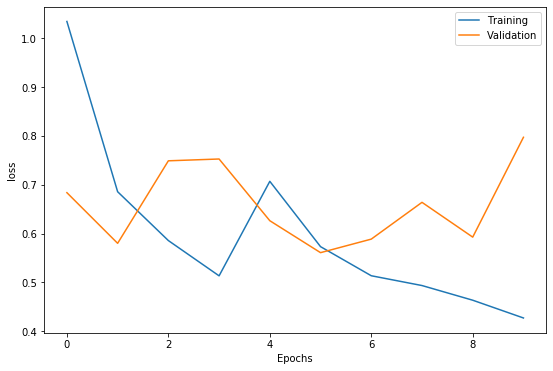

In [27]:
plot_history(history, 'loss')

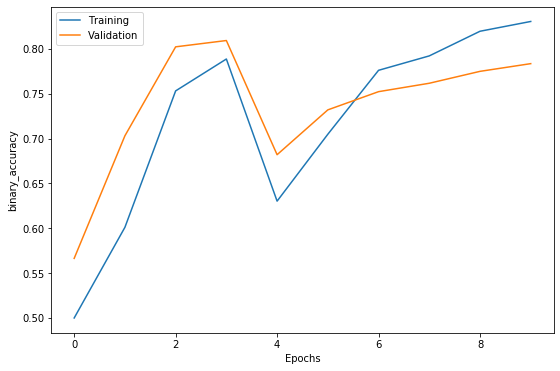

In [28]:
plot_history(history, 'binary_accuracy')